# 計算グラフ

In [2]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

- 値をエッジの重み，演算をノードとしたグラフを計算グラフと呼ぶ
- 順方向には通常の計算，逆方向には微分になる.
- 部分的な式を微分して外側の式に掛けていく，合成関数の微分をグラフ表現したもの
- 加算ノードの逆方向はそのまま計算
- 乗算ノードの逆方向は元の式からその変数を抜いたものを計算．xyなら，x方向にはy*入力って感じ

乗算レイヤの実装

In [3]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        
        return dx, dy

In [4]:
apple = 100
apple_num = 2
tax = 1.1

#layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

price

dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
print(dapple_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

dapple, dtax, dapple_num

220.00000000000003

1.1


(2.2, 200, 110.00000000000001)

$$price = apple \times apple\_num \times tax$$
のとき,  
逆伝播の結果$dapple, dtax, dapple\_num$は，  
$apple, tax, apple\_num$がそれぞれ$dprice=1$だけ増えた時，$price$がどれだけ変化するかを表している．  

たとえば，りんごの価格$apple$が1円だけ増えた時，priceは2.2円だけ増加する．  
すなわちこれは，りんごの価格の変数$apple$方向の傾きを求めていることになる．  
したがって，逆伝播は関数を微分して実際の値を入れることに相当する．  

例えば，$a=xyz$なら，$x$の逆伝播の結果は$a$方向の傾きとなる関数$a'=yz$の点$(x,y,z)$における傾きということになる．  
ここで$x$軸方向の傾きの大きさは$x$によらないことがわかる． 

計算グラフの逆伝播操作は，各エッジ(値)の勾配を求めているということになる．  
計算グラフの尻から誤差を与えてやると，誤差が大きいほど各エッジの勾配の値も大きくなる．  
この勾配に学習率をかけて元のエッジの値を傾きが小さくなる方向へ更新することを繰り返すのが，勾配降下法による学習である．

加算レイヤの実装

In [183]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [184]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
apple_orange_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(apple_orange_price, tax)

price

dprice = 1
apple_orange_price_d, tax_d = mul_tax_layer.backward(dprice)
apple_price_d, orange_price_d = add_apple_orange_layer.backward(apple_orange_price_d)
apple_d, apple_num_d = mul_apple_layer.backward(apple_price_d)
orange_d, orange_num_d = mul_orange_layer.backward(orange_price_d)

apple_orange_price_d, tax_d, apple_price_d, orange_price_d, apple_d, apple_num_d, orange_d, orange_num_d

715.0000000000001

(1.1, 650, 1.1, 1.1, 2.2, 110.00000000000001, 3.3000000000000003, 165.0)

# 活性化関数レイヤの実装

## ReLUレイヤの実装  

Rctified Linear Unit  
入力xが正ならそのまま，負なら0を返す関数  
微分すると，それぞれ1, 0となる  
順伝搬時0なら下流への信号がストップするということ  
電気回路におけるスイッチのように機能する

In [185]:
class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

In [186]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])

relu = Relu()
relu_out = relu.forward(x)
relu_out

relu_out_d = relu.backward(relu_out)
relu_out_d

array([[1., 0.],
       [0., 3.]])

array([[1., 0.],
       [0., 3.]])

## Sigmoidレイヤの実装

$$ y = \frac{1}{1 + exp(-x)}$$

順に計算グラフにするとx*-1(exp)+1/となる．  
1ステップずつ逆伝搬させると

$$ \frac{\partial L}{\partial y}y^2 exp(-x) $$

これくらいのノードはグループ化して入出力だけ考えたほうがわかりやすく，効率もいい  
上記の偏微分の式にシグモイド関数の定義式を代入すると

$$ \frac{\partial L}{\partial y} y(1-y) $$

In [187]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1 / 1 + np.exp(-x)
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        
        return dx

## Affine / Softmaxレイヤの実装

### Affine レイヤ

In [188]:
X = np.random.rand(2)
W = np.random.rand(2, 3)
B = np.random.rand(3)

X.shape
W.shape
B.shape

Y = np.dot(X, W) + B
Y

(2,)

(2, 3)

(3,)

array([1.91845902, 1.27053967, 1.16922066])

内積も扱うレイヤ  
$$ L = X \cdot W + B $$

バッチ版Affineレイヤ  
1行のベクトルではなく，N行に対応する  

バイアスの逆伝搬の時は，N行のベクトルをタテに和を取る

In [189]:
dY = np.array([[1,2,3], [4,5,6]]) # N=2のとき
dB = np.sum(dY, axis=0) # Axis設定しないとflattenされて和をとられる
dB

array([5, 7, 9])

In [190]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

### Softmax-with-Lossレイヤ

exp(x)の和でexp(x)を割って確率にする層  
Softmaxに通す前の値をスコアと呼ぶ  
推論フェーズではSoftmaxレイヤは使われない  
推論フェーズでは最大値だけわかればいい  
学習フェーズでは他の奴と比べてどうか？が欲しいため，Softmaxが必要になる

クロスエントロピー誤差も入れる  
実装を簡単化できるが，過程は付録A  
すると，この出力層の微分は，出力-教師データ と，誤差を後ろに流すことになる．  
なお，恒等関数＋2乗和誤差も微分の結果はその誤差になる．

In [191]:
"""
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a-c)
    exp_a_sum = np.sum(exp_a)
    return exp_a / exp_a_sum

def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))
"""

# このsoftmaxとcrossentropyerrorはgithubに上がってる方のコードでないといけない

def softmax(x):
    # checkで使われるのはこっち
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    
    # 従来のsoftmax
    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    # softmax + cross entropy errorの逆伝播はy - tになる
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size # n個のデータの誤差を見たので，Nで割る
        return dx

'\ndef softmax(a):\n    c = np.max(a)\n    exp_a = np.exp(a-c)\n    exp_a_sum = np.sum(exp_a)\n    return exp_a / exp_a_sum\n\ndef cross_entropy_error(y, t):\n    delta = 1e-7\n    return -np.sum(t * np.log(y + delta))\n'

# 誤差逆伝搬法の実装

- ミニバッチを取ってくる
- 損失関数で求めた値から，勾配を求める
- パラメータを更新する
- 上記ステップを繰り返す

In [192]:
def numerical_gradient_for_a_vector(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        x[idx] = float(tmp_val) - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
    
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return numerical_gradient_for_a_vector(f, X)
    else:
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_for_a_vector(f, x)
        
        return grad

In [193]:
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 追加部分
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    
    # Xは何個でも画像をもらえる．それぞれの画像に対する予測結果を返す．
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) # デフォルトは縦でargmaxを求めてしまう．1行の中の最大値が推測結果．
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 数値微分による勾配の計算，遅い．何度も「ちょっと重みを変えてpredict」を行う．
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        
        return grads

    # 誤差逆伝搬法による勾配の計算，早い．1回のpredictでいい．
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        #backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [194]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key, ":", str(diff))

W1 : 3.885315542475368e-10
b1 : 2.476091421996663e-09
W2 : 5.377092578844242e-09
b2 : 1.4005354904977896e-07


## 誤差逆伝搬法を使った学習

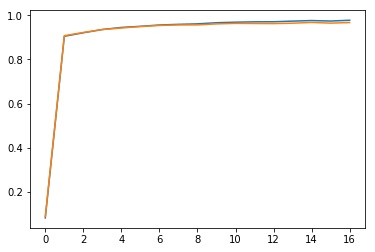

In [198]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # ここが4章とは違う！誤差逆伝搬法を使っている
    grad = network.gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', "b2"):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        # print(train_acc, test_acc)

X1 = np.arange(0, len(train_acc_list))
X2 = np.arange(0, len(test_acc_list))
plt.plot(X1, train_acc_list)
plt.plot(X2, test_acc_list)

めちゃはやい！！

まとめ  
勾配が求まったら，その全てのベクトルに学習率をかけてパラメータを更新する．この勾配を求めるのを高速化したかった．  
勾配を数値微分で求める＝＞パラメータすべてに対して，少し変えてlossを求める，を繰り返すので，めちゃ遅い  
勾配を誤差逆伝搬法で求める＝＞計算グラフの考え方で，後ろの層の微小変化に対し，行列計算で一気に勾配ベクトル(微分)を求められる  

1を出力側から与えて計算グラフを次の規則に従って逆に計算していくと，各辺(値)の微分値が求まる．  
乗算レイヤ：xyzなら，xにはyzが逆伝搬   
加算レイヤ：xyzなら，xにはxが逆伝搬  
ReLuレイヤ：入力が正なら1，そうでなければ0を逆伝搬  
Sigmoidレイヤ：$$ \frac{\partial L}{\partial y} y(1-y) $$ が逆伝搬，偏微分のところは，出力側から与えられる微小変化  
Affineレイヤ：入力ベクトルに重みとバイアスを与えるレイヤ，重みとバイアスの辺に，それぞれベクトルと値を行列の積によって返す  
Softmax with Lossレイヤ：出力と正解の差が逆伝搬するよう設計された層．  
恒等関数には２乗誤差，Softmaxにはクロスエントロピーを使うことで，ただその差が逆伝搬する  

詳しくは，付録Aやディープラーニングがわかる数学入門で！